## Welcome to your notebook.


#### Run this cell to connect to your GIS and get started:

In [1]:
import arcpy
import os
from arcpy.sa import *
from arcpy.sfa import *
from arcpy import env
import csv
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
arcpy.env.overwriteOutput = True

In [3]:
path = "C:/Users/eespey/Documents/W22/Python_for_GDSb/Wind_project/data" #path to all the data

In [4]:
nrel = pd.read_csv(os.path.join(path, 'nrel_wtk/wtk_site_metadata.csv')) #read in csv of NREL WTK dataset

In [5]:
arcpy.management.XYTableToPoint(os.path.join(path, 'nrel_wtk/wtk_site_metadata.csv'), os.path.join(path,'nrel_wtk/wtk_to_points'), 'longitude', 'latitude') #make a point shapefile from the csv file

<Result 'C:\\Users\\eespey\\Documents\\W22\\Python_for_GDSb\\Wind_project\\data\\nrel_wtk\\wtk_to_points.shp'>

In [6]:
elevation = arcpy.Raster(os.path.join(path,'Elevation_GRID/NA_Elevation/NA_Elevation.lyr')) #read in elevation data

In [7]:
ws_100m = arcpy.Raster(os.path.join(path,'us-wind-data/wtk_conus_100m_mean_masked.tif')) #read in wind speed at 100m

In [8]:
nrel_all_points = os.path.join(path,'nrel_wtk/wtk_to_points.shp')
states = os.path.join(path, 'cb_2018_us_cd116_500k/cb_2018_us_cd116_500k.shp')
arcpy.analysis.Clip(nrel_all_points, states, os.path.join(path, 'nrel_wtk/wtk_to_points_clip')) #clip nrel points to CONUS

<Result 'C:\\Users\\eespey\\Documents\\W22\\Python_for_GDSb\\Wind_project\\data\\nrel_wtk\\wtk_to_points_clip.shp'>

In [9]:
nrel_points = os.path.join(path, 'nrel_wtk/wtk_to_points_clip.shp')

In [11]:
elevation = ExtractByMask(elevation, ws_100m) #clip elevation

In [13]:
ws_100m = ExtractByMask(ws_100m, elevation) #clip wind speed
#ws_100m

In [15]:
ws_cu = pow(ws_100m,3) #calculate wind speed cubed (this is what power output of a turbine is dependent on)
#ws_cu

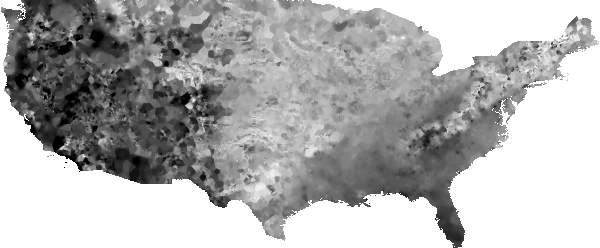

In [16]:
idw = Idw(nrel_points, 'capacity_f') #run idw using capacity factor in nrel points shapefile
idw_clip = ExtractByMask(idw, elevation) #clip to CONUS
idw_clip.save(os.path.join(path,'output/idw'))
idw_clip

In [17]:
slope = Slope(elevation, "DEGREES","GEODESIC","METERS") #calculate slope
#slope

In [18]:
# extract the elvation value, the slope value, wind speed at 100m, and wind speed cubed, then append it to the turbine point data
ExtractMultiValuesToPoints(nrel_points, [[slope, 'slope'], [elevation, 'elev'], [ws_100m, 'ws_100m'], [ws_cu, 'ws_cu']])

<geoprocessing server result object at 0x17ff343b1e0>

In [19]:
inTable = nrel_points
outLocation = os.path.join(path, 'output/regression')
outTable = "points_table.csv"

arcpy.TableToTable_conversion(inTable, outLocation, outTable) #convert attribute table of nrel points to csv

<Result 'C:/Users/eespey/Documents/W22/Python_for_GDSb/Wind_project/data\\output/regression\\points_table.csv'>

In [20]:
points_table = pd.read_csv(os.path.join(outLocation, outTable))

In [21]:
points_table.head() #check the columns look right

,OID_,site_id,longitude,latitude,State,County,fraction_o,power_curv,capacity,wind_speed,capacity_f,full_times,full_tim_1,slope,elev,ws_100m,ws_cu
0,0,3147,-100.438873,28.732224,Texas,Maverick,1.0000,3,16,6.48,0.344,6,6/3147.nc,0.096725,263,6.47627,271.627991
1,1,4251,-100.754211,29.164719,Texas,Kinney,0.9418,3,16,6.43,0.341,8,8/4251.nc,0.310052,254,6.40812,263.143005
2,2,4300,-100.755432,29.182613,Texas,Kinney,1.0000,3,16,6.54,0.353,8,8/4300.nc,0.158976,262,6.49489,273.977997
3,3,4346,-100.756653,29.200493,Texas,Kinney,1.0000,3,16,6.65,0.367,8,8/4346.nc,0.385568,275,6.59603,286.977997
4,4,4402,-100.778381,29.217331,Texas,Kinney,0.5503,3,10,6.47,0.368,8,8/4402.nc,0.077013,255,6.40600,262.881988


In [34]:
x_col = ["slope", "elev", 'ws_100m', 'ws_cu'] #independent variables
y = points_table["capacity_f"] #response variable

def get_stats():
    x = points_table[x_col]
    results = sm.OLS(y, x).fit() #perform regression
    print(results.summary()) #print regression results
stats = get_stats()

                                 OLS Regression Results                                
Dep. Variable:             capacity_f   R-squared (uncentered):                   0.928
Model:                            OLS   Adj. R-squared (uncentered):              0.928
Method:                 Least Squares   F-statistic:                          3.601e+05
Date:                Mon, 11 Apr 2022   Prob (F-statistic):                        0.00
Time:                        17:38:09   Log-Likelihood:                          86915.
No. Observations:              111382   AIC:                                 -1.738e+05
Df Residuals:                  111378   BIC:                                 -1.738e+05
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

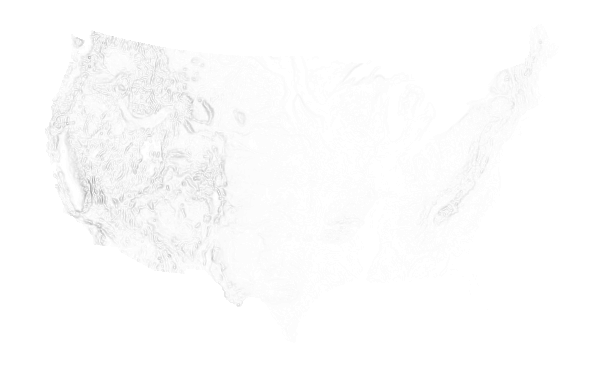

In [23]:
slope_weighted = arcpy.sa.Times(slope, -6.626e-06) #apply regression weighting to slope
slope_weighted

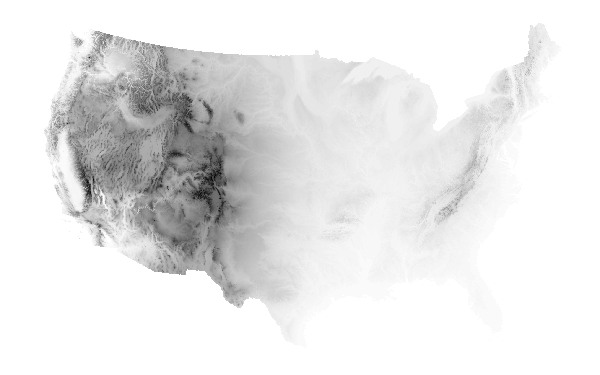

In [24]:
elev_weighted = arcpy.sa.Times(elevation, -7.642e-06) #apply regression weighting to elevation
elev_weighted

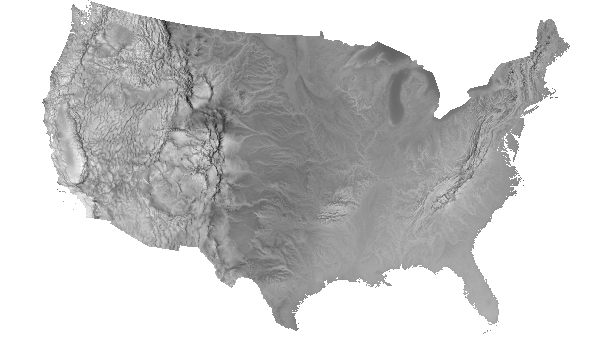

In [25]:
ws_weighted = arcpy.sa.Times(ws_100m, -0.0009) #apply regression weighting to wind speed
ws_weighted

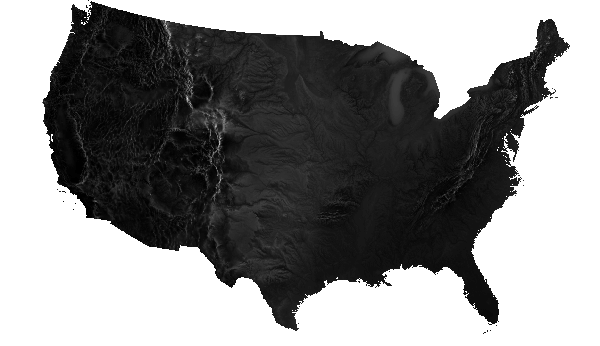

In [26]:
ws_cu_weighted = arcpy.sa.Times(ws_cu, 0.0008) #apply regression weighting to wind speed cubed
ws_cu_weighted

In [28]:
weighted = arcpy.sa.Plus(slope_weighted, ws_weighted)
weighted = arcpy.sa.Plus(weighted, ws_cu_weighted)
weighted = arcpy.sa.Plus(weighted, elev_weighted)
weighted.save(os.path.join(path,'output/cf_reg_weights.tif')) #add all weighted layers

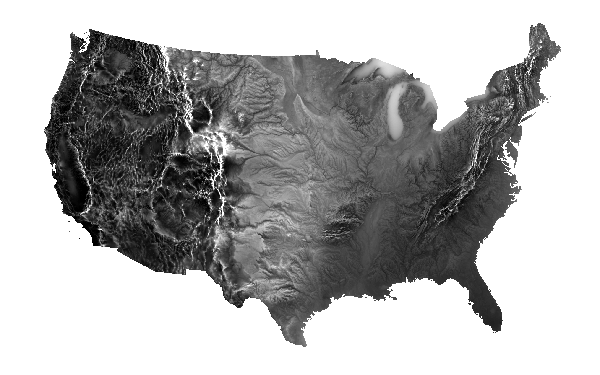

In [29]:
weighted

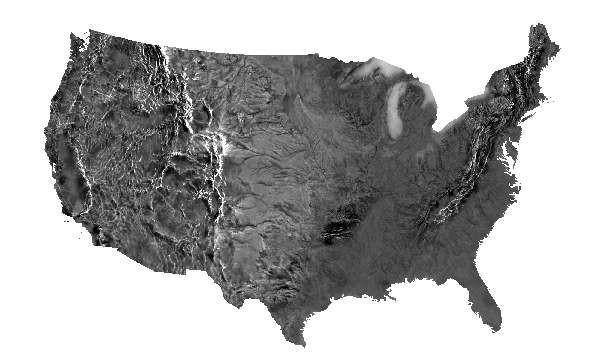

In [30]:
diff = arcpy.sa.Minus(weighted, idw)
diff.save(os.path.join(path,'output/diff.tif')) #calculate difference between IDW and regression
diff

In [46]:
absolute_diff = abs(diff)
absolute_diff.save(os.path.join(path,'output/diff_abs.tif'))

In [50]:
weighted.maximum

2.2512269020080566

In [51]:
absolute_diff.minimum

3.6507844924926758e-06